# Model Training
Welcome to the 'Model Training and Prediction' notebook, a crucial facet of our project's data science pipeline. In this notebook, we offer a meticulous examination of our rigorous model development process. The pipeline starts by accepting training data, followed by fitting three distinct types of models to it: Random Forest, Gradient Boosted Tree, and XGBoost. The initial stages include encoding categorical variables and executing Recursive Feature Elimination (RFE) for feature selection. This is succeeded by the application of genetic algorithms to hyperparameter tuning, operating in tandem with a cross-validation routine. Subsequently, the best model is selected based on the highest F1 score, indicating the balance between precision and recall. Finally, the selected model is utilized to predict the outcomes for the current week's round of NRL matches. This process is iterative and cyclical, with the potential for revisiting earlier stages based on the model's performance. Let us proceed with this in-depth exploration.

## Set up Environment
This code segment is setting up the environment for the model training pipeline. It begins by importing sys and pathlib - Python libraries used for managing system parameters and file paths, respectively.

The code then updates the system path to include the "functions" directory. This allows for the import of custom modules `modelling_functions`, `model_properties`, and `training_config` which are stored in this directory. These modules contain custom functions and configuration settings that are critical for the later stages of data preprocessing, model training, and prediction.

Following this, the `project_root` variable is defined. This is achieved by using the pathlib library to establish the root directory of the project.

Finally, the `db_path` variable is constructed. This is the relative path to the SQLite database "footy-tipper-db.sqlite", which is located in the "data" directory of the project root. This path will be used for database connectivity throughout the pipeline.

In [1]:
# import libraries
import os
import sys
import pathlib

cwd = os.getcwd()

# get the parent directory
parent_dir = os.path.dirname(cwd)

# add the parent directory to the system path
sys.path.insert(0, parent_dir)

# Get to the root directory
project_root = pathlib.Path().absolute().parent

# import functions from common like this:
from pipeline.common.model_training import (
    training_config as tc,
    modelling_functions as mf,
    model_properties as mp
)

from pipeline.common.model_prediciton import prediction_functions as pf

## Get data
Our process starts by establishing the root directory of the project and constructing the relative path to the 'footy-tipper-db.sqlite' database located within the 'data' directory. We then connect to this SQLite database and use a SQL query housed in the 'footy_tipping_data.sql' file, found in the 'sql' directory, to extract the required data. This data is loaded into a pandas DataFrame, footy_tipping_data, serving as the basis for our subsequent modeling activities. Upon successful extraction of the data, we ensure the database connection is closed, maintaining good coding practice and resource management.

In [2]:
training_data = mf.get_training_data(
    db_path = project_root / "data" / "footy-tipper-db.sqlite", 
    sql_file = project_root / 'pipeline/common/sql/training_data.sql')

training_data

,game_id,round_id,round_name,game_number,game_state_name,start_time,start_time_utc,venue_name,city,crowd,...,away_prev_result_diff,prev_result_diff,home_elo,away_elo,elo_diff,home_elo_prob,away_elo_prob,elo_draw_prob,elo_prob_diff,home_ground_advantage
0,2.018111e+10,1.0,Round 1,1.0,Final,1.520540e+09,1.520500e+09,Netstrata Jubilee Stadium,Sydney,14457.0,...,0.0,0.0,1498.871776,1510.436561,-11.564785,0.467857,0.492421,0.039722,-0.024564,3.493947
1,2.018111e+10,1.0,Round 1,2.0,Final,1.520618e+09,1.520579e+09,McDonald Jones Stadium,Newcastle,23516.0,...,0.0,0.0,1484.766828,1496.167248,-11.400420,0.468084,0.492194,0.039722,-0.024110,6.932228
2,2.018111e+10,1.0,Round 1,3.0,Final,1.520622e+09,1.520586e+09,1300SMILES Stadium,Townsville,15900.0,...,0.0,0.0,1506.226230,1503.248120,2.978110,0.487951,0.472327,0.039722,0.015624,0.955843
3,2.018111e+10,1.0,Round 1,4.0,Final,1.520699e+09,1.520660e+09,Accor Stadium,Sydney,18243.0,...,0.0,0.0,1493.848754,1500.976808,-7.128054,0.473986,0.486292,0.039722,-0.012306,-2.978035
4,2.018111e+10,1.0,Round 1,5.0,Final,1.520698e+09,1.520669e+09,Other,Perth,38824.0,...,0.0,0.0,1490.493737,1483.488252,7.005485,0.493514,0.466764,0.039722,0.026750,4.315751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317,2.024111e+10,18.0,Round 18,4.0,Final,1.720278e+09,1.720242e+09,Accor Stadium,Sydney,27223.0,...,60.0,-59.0,1511.360142,1488.692560,22.667582,0.521733,0.450911,0.027356,0.070822,1.936236
1318,2.024111e+10,18.0,Round 18,5.0,Final,1.720287e+09,1.720251e+09,Leichhardt Oval,Sydney,10311.0,...,-6.0,30.0,1457.994294,1528.130944,-70.136650,0.400985,0.591264,0.007752,-0.190279,-8.892546
1319,2.024111e+10,18.0,Round 18,6.0,Final,1.720294e+09,1.720258e+09,Queensland Country Bank Stadium,Townsville,18787.0,...,14.0,-44.0,1502.064761,1506.824271,-4.759509,0.477259,0.483019,0.039722,-0.005761,1.101418
1320,2.024111e+10,18.0,Round 18,7.0,Final,1.720361e+09,1.720325e+09,Allianz Stadium,Sydney,23388.0,...,16.0,18.0,1551.887506,1501.545036,50.342470,0.565786,0.416973,0.017241,0.148813,12.045402


## Modelling
During the modelling phase, the `train_and_select_best_model` function, part of our `modelling_functions` module, is invoked. This function initiates the training of three distinct models: XGBoost, Random Forest, and Gradient Boosting Classifier. It takes as input the footy tipping data, predictor variables, the outcome variable, and several configuration settings like whether to use Recursive Feature Elimination (RFE), the number of cross-validation folds, and the optimization metric, all sourced from the `training_config` module.

The function first identifies categorical columns in the feature set for one-hot encoding, creating dummy variables for categorical features. Depending on the choice of using RFE, a feature elimination step may be included in the pipeline. Each model subsequently undergoes hyperparameter tuning using a genetic algorithm, facilitated by the `GASearchCV` function.

All the models are then trained and evaluated through cross-validation. The best model, or `footy_tipper`, is selected based on the superior performance on the chosen optimization metric. Additionally, a `LabelEncoder`(`label_encoder`), used to encode the categorical target variable, is returned. This LabelEncoder is specific to the model that performed best. The selected model, encapsulated in a pipeline with pre-processing steps and hyperparameter tuning, is now ready for the prediction phase.

### Basic Model

In [ ]:
# footy_tipper, label_encoder = mf.train_and_select_best_model(
#     training_data, tc.predictors, tc.outcome_var,
#     tc.use_rfe, tc.num_folds, tc.opt_metric
# )
# footy_tipper

### Poisson Modelling

#### Make the models

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load your dataset
data = training_data

# Define features and target variables
features = data[tc.predictors]

home_scores = data['team_final_score_home']
away_scores = data['team_final_score_away']

# Preprocess categorical features
categorical_features = ["round_name", "venue_name", "city", "team_home", "team_away"]
numeric_features = ["round_id", "game_number"]

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ])

# Poisson regression model
model = xgb.XGBRegressor(objective='count:poisson', n_estimators=100, random_state=69)

# Create a pipeline that first transforms the data and then fits the model
home_pipeline = away_pipeline = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('model', model)])

# Split data into training and testing sets for home scores
X_train_home, X_test_home, y_train_home, y_test_home = train_test_split(
    features, home_scores, test_size=0.2, random_state=69)

# Split data into training and testing sets for away scores
X_train_away, X_test_away, y_train_away, y_test_away = train_test_split(
    features, away_scores, test_size=0.2, random_state=69)

# Train the Poisson regression models for home and away scores
home_pipeline.fit(X_train_home, y_train_home)
away_pipeline.fit(X_train_away, y_train_away)

# Predict scores
home_score_preds = home_pipeline.predict(X_test_home)
away_score_preds = away_pipeline.predict(X_test_away)

# Calculate evaluation metrics for home scores
mae_home = mean_absolute_error(y_test_home, home_score_preds)
mse_home = mean_squared_error(y_test_home, home_score_preds)
r2_home = r2_score(y_test_home, home_score_preds)

# Calculate evaluation metrics for away scores
mae_away = mean_absolute_error(y_test_away, away_score_preds)
mse_away = mean_squared_error(y_test_away, away_score_preds)
r2_away = r2_score(y_test_away, away_score_preds)

print("Home Scores - MAE: {:.2f}, MSE: {:.2f}, R²: {:.2f}".format(mae_home, mse_home, r2_home))
print("Away Scores - MAE: {:.2f}, MSE: {:.2f}, R²: {:.2f}".format(mae_away, mse_away, r2_away))

Home Scores - MAE: 10.75, MSE: 203.33, R²: -0.34
Away Scores - MAE: 8.69, MSE: 125.08, R²: -0.00


Expected Home Score: 17.47
Expected Away Score: 17.42


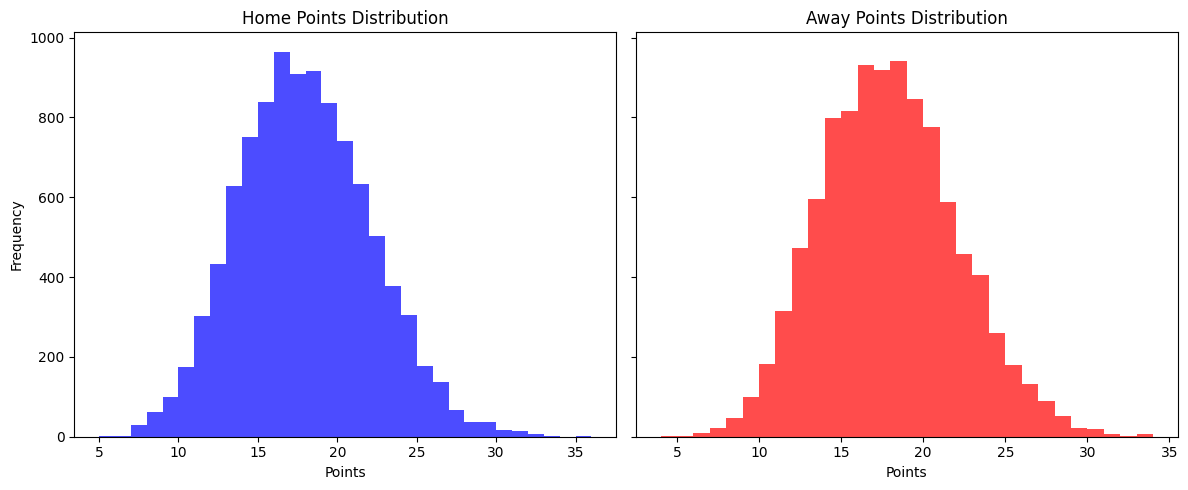

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_match(home_lambda, away_lambda, n_simulations=10000):
    home_points = np.random.poisson(home_lambda, n_simulations)
    away_points = np.random.poisson(away_lambda, n_simulations)
    return home_points, away_points

# Example for one match (using the first test sample)
home_lambda = home_score_preds[0]
away_lambda = away_score_preds[0]
n_simulations = 10000

home_points, away_points = simulate_match(home_lambda, away_lambda, n_simulations)

# Calculate expected scores
expected_home_score = np.mean(home_points)
expected_away_score = np.mean(away_points)

print(f"Expected Home Score: {expected_home_score:.2f}")
print(f"Expected Away Score: {expected_away_score:.2f}")

# Plot the distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Home points distribution
axes[0].hist(home_points, bins=range(min(home_points), max(home_points) + 1), alpha=0.7, color='blue')
axes[0].set_title('Home Points Distribution')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Frequency')

# Away points distribution
axes[1].hist(away_points, bins=range(min(away_points), max(away_points) + 1), alpha=0.7, color='red')
axes[1].set_title('Away Points Distribution')
axes[1].set_xlabel('Points')

plt.tight_layout()
plt.show()

In [5]:
# Calculate win/loss probabilities
home_wins = np.sum(home_points > away_points) / n_simulations
away_wins = np.sum(home_points < away_points) / n_simulations
draws = np.sum(home_points == away_points) / n_simulations

print(f"Home Win Probability: {home_wins:.2f}")
print(f"Away Win Probability: {away_wins:.2f}")
print(f"Draw Probability: {draws:.2f}")

Home Win Probability: 0.47
Away Win Probability: 0.46
Draw Probability: 0.07


In [7]:
import numpy as np

# Function to simulate matches
def simulate_match(home_lambda, away_lambda, n_simulations=10000):
    home_goals = np.random.poisson(home_lambda, n_simulations)
    away_goals = np.random.poisson(away_lambda, n_simulations)
    return home_goals, away_goals

# Initialize lists to store results
simulated_home_wins = []
simulated_away_wins = []
simulated_draws = []

# Loop through each sample in the test set
for i in range(len(X_test_home)):
    home_lambda = home_score_preds[i]
    away_lambda = away_score_preds[i]
    
    home_goals, away_goals = simulate_match(home_lambda, away_lambda)
    
    home_wins = np.sum(home_goals > away_goals) / len(home_goals)
    away_wins = np.sum(home_goals < away_goals) / len(home_goals)
    draws = np.sum(home_goals == away_goals) / len(home_goals)
    
    simulated_home_wins.append(home_wins)
    simulated_away_wins.append(away_wins)
    simulated_draws.append(draws)

# Create a DataFrame to store the results
simulation_results = pd.DataFrame({
    'home_win_prob': simulated_home_wins,
    'away_win_prob': simulated_away_wins,
    'draw_prob': simulated_draws,
    'actual_home_score': y_test_home.values,
    'actual_away_score': y_test_away.values
})

# Function to determine the match outcome based on actual scores
def actual_outcome(row):
    if row['actual_home_score'] > row['actual_away_score']:
        return 'home_win'
    elif row['actual_home_score'] < row['actual_away_score']:
        return 'away_win'
    else:
        return 'draw'

# Add the actual outcomes to the DataFrame
simulation_results['actual_outcome'] = simulation_results.apply(actual_outcome, axis=1)

# Function to determine the predicted outcome based on the highest probability
def predicted_outcome(row):
    if row['home_win_prob'] > row['away_win_prob'] and row['home_win_prob'] > row['draw_prob']:
        return 'home_win'
    elif row['away_win_prob'] > row['home_win_prob'] and row['away_win_prob'] > row['draw_prob']:
        return 'away_win'
    else:
        return 'draw'

# Add the predicted outcomes to the DataFrame
simulation_results['predicted_outcome'] = simulation_results.apply(predicted_outcome, axis=1)

# Calculate the accuracy of the predictions
accuracy = np.mean(simulation_results['actual_outcome'] == simulation_results['predicted_outcome'])
print(f"Simulation Accuracy: {accuracy:.2f}")

# Optional: Display the simulation results
simulation_results

Simulation Accuracy: 0.48


,home_win_prob,away_win_prob,draw_prob,actual_home_score,actual_away_score,actual_outcome,predicted_outcome
0,0.4557,0.4757,0.0686,44.0,4.0,home_win,away_win
1,0.4636,0.4714,0.0650,8.0,20.0,away_win,away_win
2,0.4630,0.4815,0.0555,12.0,36.0,away_win,away_win
3,0.4539,0.4502,0.0959,0.0,38.0,away_win,home_win
4,0.4754,0.4744,0.0502,18.0,36.0,away_win,home_win
...,...,...,...,...,...,...,...
260,0.4705,0.4658,0.0637,18.0,34.0,away_win,home_win
261,0.4631,0.4585,0.0784,12.0,26.0,away_win,home_win
262,0.4606,0.4492,0.0902,14.0,24.0,away_win,home_win
263,0.4689,0.4720,0.0591,18.0,26.0,away_win,away_win


### Display feature importance
The `get_feature_importance` function retrieves feature importances from a trained scikit-learn pipeline. It accounts for different transformations, such as one-hot encoding and recursive feature elimination. The function then returns a sorted DataFrame listing each feature alongside its respective importance, aiding in understanding the model's decision-making process.

In [ ]:
# feature_importance_df = mp.get_feature_importances_from_pipeline(footy_tipper, tc.predictors)
# feature_importance_df

## Save Model
The `save_models` function stores the trained LabelEncoder and Pipeline objects to the disk. This allows for easy retrieval and reuse in future model prediction tasks, without the need to retrain these components. The objects are stored in a designated 'models' directory under the project root path, ensuring organized and consistent storage.

In [ ]:
mf.save_models(label_encoder, footy_tipper, project_root)

## Predict
The final stage of the pipeline involves predicting the outcomes of the current week's NRL matches. This is achieved by connecting to the SQLite database and extracting the required data. The trained model and LabelEncoder are then loaded from the disk, and the prediction is performed using the `model_predictions` function. The predictions are stored in the 'predictions' table of the database, allowing for easy retrieval and analysis.

In [ ]:
label_encoder, footy_tipper = pf.load_models(project_root)

In [ ]:
inference_data = pf.get_inference_data(
    db_path = project_root / "data" / "footy-tipper-db.sqlite", 
    sql_file = project_root / 'pipeline/common/sql/inference_data.sql')
inference_data

In [ ]:
predictions_df = pf.model_predictions(footy_tipper, inference_data, label_encoder)
predictions_df

In [ ]:
pf.save_predictions_to_db(
    predictions_df, 
    project_root / "data" / "footy-tipper-db.sqlite", 
    project_root / 'pipeline/common/sql/create_table.sql', 
    project_root / 'pipeline/common/sql/insert_into_table.sql'
)

# this is the sending bit

In [ ]:
from dotenv import load_dotenv
from pipeline.common.model_prediciton import prediction_functions as pf
from pipeline.common.use_predictions import sending_functions as sf

# Now construct the relative path to your SQLite database
db_path = project_root / "data" / "footy-tipper-db.sqlite"
secrets_path = project_root / "secrets.env"
json_path = project_root / "service-account-token.json"

load_dotenv(dotenv_path=secrets_path)

In [ ]:
import sqlite3
import pandas as pd
# Connect to the SQLite database
con = sqlite3.connect(str(db_path))

# Read SQL query from external SQL file
with open(project_root / 'pipeline/common' / 'sql/prediction_table.sql', 'r') as file:
    query = file.read()

# Execute the query and fetch the results into a data frame
predictions = pd.read_sql_query(query, con)

# Disconnect from the SQLite database
con.close()

predictions

In [ ]:
tipper_picks = sf.get_tipper_picks(predictions)
tipper_picks

In [ ]:
sf.upload_df_to_drive(
    predictions, 
    json_path, 
    os.getenv('FOLDER_ID'), 
    "predictions.csv"
)

In [ ]:
reg_reagan = sf.generate_reg_regan_email(
    predictions, 
    tipper_picks, 
    os.getenv('OPENAI_KEY'), 
    os.getenv('FOLDER_URL'),
    1
)

print(reg_reagan)

In [ ]:
sf.send_emails(
    "footy-tipper-email-list", 
    f"Footy Tipper Predictions for {predictions['round_name'].unique()[0]}", 
    reg_reagan, 
    os.getenv('MY_EMAIL'), 
    os.getenv('EMAIL_PASSWORD'), 
    json_path
)